# Figure SI 1: S100A4 energy unit analysis

## Imports

In [1]:
%matplotlib inline
import matplotlib
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd

# Required input files:
# muts_ddGs.npz
# max_epistasis_additivestates15.npz
# max_epistasis_additivestates.npz

# Some pretty plot defaults
font = {'family' : 'Arial',
        'weight' : 'normal',
        'size'   : 16}

matplotlib.rc('font', **font)

matplotlib.rcParams['axes.spines.right'] = False
matplotlib.rcParams['axes.spines.top'] = False

## Load data from ROSETTA. 

Each line of the text file (output-cycles.txt) has 20 entries in the following order, delimited by commas, with no line breaks.  
(Spacing and line breaks here for human sanity).
```
mut_one,mut_two,

apo_mean_ddG_m1,apo_mean_ddG_m2,apo_mean_ddG_m1m2,
ca_mean_ddG_m1,ca_mean_ddG_m2,ca_mean_ddG_m1m2,
capep_mean_ddG_m1,capep_mean_ddG_m2,capep_mean_ddG_m1m2,

apo_std_ddG_m1,apo_std_ddG_m2,apo_std_ddG_m1m2,
ca_std_ddG_m1,ca_std_ddG_m2,ca_std_ddG_m1m2,
capep_std_ddG_m1,capep_std_ddG_m2,capep_std_ddG_m1m2
```

+ `mut_one` and `mut_two` are human-readable names of the mutations (like V72K, etc.)
+ `apo`, `ca`, and `capep` refer to the state on which the calculation was done. 
+ `mean` and `std` indicate whether this is the mean ddG calcualted or the standard deviation on the set of ddG calcultions. 
+ `m1`, `m2`, and `m1m2` refer to whether this is the effect of mutation 1, mutation 2, or mutation 1 and 2 together.  For most mutations, the `m1m2` value is `np.na` because the calculation was not done. 
+ energies are in ROSETTA energy units

In [2]:
def count_lines_in_file(filename):
    """
    Very quickly count the number of lines in a file.
    
    Following this discusssion:
    
    # https://stackoverflow.com/questions/9629179/python-counting-lines-in-a-huge-10gb-file-as-fast-as-possible
    """
    
    def blocks(files, size=65536):
        while True:
            b = files.read(size)
            if not b: break
            yield b

    
    with open(filename, "r",encoding="utf-8",errors='ignore') as f:
        count = sum(bl.count("\n") for bl in blocks(f))
        
    return count


file_with_cycles = "output-cycles.txt"

num_lines = count_lines_in_file(file_with_cycles)

apo_ddG_mean = np.zeros((num_lines,3),dtype=np.float)
ca_ddG_mean = np.zeros((num_lines,3),dtype=np.float)
capep_ddG_mean = np.zeros((num_lines,3),dtype=np.float)

apo_ddG_std = np.zeros((num_lines,3),dtype=np.float)
ca_ddG_std = np.zeros((num_lines,3),dtype=np.float)
capep_ddG_std = np.zeros((num_lines,3),dtype=np.float)

muts = [[None,None] for _ in range(num_lines)]

with open("output-cycles.txt") as f:
    for i, line in enumerate(f.readlines()):
        
        col = line.split(",")
        muts[i][0] = col[0]
        muts[i][1] = col[1]

        data = np.array(col[2:],dtype=np.float)
        
        apo_ddG_mean[i,:] = data[0:3]
        ca_ddG_mean[i,:] = data[3:6]
        capep_ddG_mean[i,:] = data[6:9]

        apo_ddG_std[i,:] = data[9:12]
        ca_ddG_std[i,:] = data[12:15]
        capep_ddG_std[i,:] = data[15:18]        
        
muts = np.array(muts,dtype=np.str)

## Establish reduced temperature factor

In [3]:
# If score is in kcal/mol
beta_kcal = 1/(0.001987*298)
print("kcal/mol",beta_kcal)

# Reduced temperature units
beta = 1.0
print("reduced",beta)

# if score of 10 is 5 kJ/mol:
beta_kj = 1/(0.008314*298)
print("kJ/mol",beta_kj)


kcal/mol 1.6888297423183578
reduced 1.0
kJ/mol 0.4036209643957875


## Define constants

In [4]:
BETA =      1.0 # energy units (reduced)
MU_PEP =  -20.5 # pep chemical potential is -10.5 kT
DG_APO =  -10.0 # apo form is favored by 10 kT
DG_CA  =    0.0 # ca form stability 0 @ calcium Kd. 
DG_CAPEP =  10 # capep form stability 0 (@ calcium Kd and peptide Kd)
MU_CA_RANGE = np.arange(-30,30.1,.1) # Calcium chemical potential range for calculations

## Define observables 

Free energy of each state is: 
$$\Delta G^{\circ}_{x} + \Delta \Delta G_{x,mut} + \sum \mu_{x}$$

Weight is:

$$w_{x} = e^{-\Delta G_{x} /RT}$$

Observable is:

$$\theta = \frac{w_{Ca+pep}}{w_{apo} + w_{Ca} + w_{Ca+pep}}$$

Assume that $\Delta G_{apo}$ is $10 kT$ more stable than Ca state and $20 kT$ more stable than ca/peptide state. 

## Functions for calculating fractional populations, peptide binding observable, and Ca-dep epistasis

In [5]:
def pops(ddG_apo=0,ddG_ca=0,ddG_capep=0,   
         mu_ca=-15,mu_pep=-20.5,                      
         dG_apo=-10,dG_ca=0,dG_capep=10,           
         beta=1.0):
    """
    Calculate the relative fraction of apo, ca, capep
    
    apo_ddG: effect of mutations on apo stability
    ca_ddG: effect of mutations on ca stability
    capep_ddG: effect of mutations on capep stability
    apo_dG: free energy of apo state
    ca_dG: free energy of ca state (no ca)
    capep_dG: free energy of ca/pep state (no ca, no pep)
    mu_pep: chemical potential of peptide
    mu_ca: chemical potential of calcium
    beta: 1/RT    
    
    Returns the fractional populations of apo, ca, and capep
    """
    
    w_apo =    np.exp(-beta*(dG_apo + ddG_apo))
    w_ca =     np.exp(-beta*(dG_ca  + ddG_ca + mu_ca))
    w_capep =  np.exp(-beta*(dG_capep + ddG_capep + mu_ca + mu_pep))
    
    Z = w_apo + w_ca + w_capep

    return w_apo/Z, w_ca/Z, w_capep/Z

def dg_obs(ddG_apo=0,ddG_ca=0,ddG_capep=0,          # effects of mutations
           mu_ca=-15,mu_pep=-20.5,                  # chemical potential of calcium and peptide
           dG_apo=-10,dG_ca=0,dG_capep=10,           # wildtype thermodynamic parameters
           beta=1.0):                               # 1/RT
    """
    Calculate the free energy of the capep state.
    
    apo_ddG: effect of mutations on apo stability
    ca_ddG: effect of mutations on ca stability
    capep_ddG: effec of mutations on capep stability
    apo_dG: free energy of apo state
    ca_dG: free energy of ca state (no ca)
    capep_dG: free energy of ca/pep state (no ca, no pep)
    mu_pep: chemical potential of peptide
    mu_ca: chemical potential of calcium
    beta: 1/RT    
    
    Returns dG(apo + ca -> capep)
    """
    
    w_apo, w_ca, w_capep = pops(ddG_apo,ddG_ca,ddG_capep,
                                mu_ca,mu_pep,
                                dG_apo,dG_ca,dG_capep,
                                beta)
    
    return -(1/beta)*np.log(w_capep/(w_apo + w_ca))

def epistasis_vs_ca(apo_ddG,ca_ddG,capep_ddG,
                    dG_apo=-10,dG_ca=0,dG_capep=10,
                    mu_pep=-20.5,mu_ca_range=np.arange(-30,30,0.1),
                    additive_in_states=True,beta=1.0):
    """
    Calculate epistasis for the system as a function of calcium concentration.
    
    apo_ddG: effect of mutation 1, mutation 2, and mutation 12 on apo stability
    ca_ddG: effect of mutation 1, mutation 2, and mutation 12 on ca stability
    capep_ddG: effect of mutation 1, mutation 2, and mutation 12 on capep stability
    apo_dG: free energy of apo state
    ca_dG: free energy of ca state (no ca)
    capep_dG: free energy of ca/pep state (no ca, no pep)
    mu_pep: chemical potential of peptide
    mu_ca_range: chemical potential range of calcium
    additive_in_states: assume that ddG terms sum within each state. If False,
                        the ddG effect of the double mutant would need to 
                        have been calculated in rosetta.
    beta: 1/RT
    """
    
        
    # If we are assuming mutations are additive within a state, 
    # throw out the (possibly) calculated ddG12 value. 
    if additive_in_states:
        apo_ddG[2] = apo_ddG[0] + apo_ddG[1]
        ca_ddG[2] = ca_ddG[0] + ca_ddG[1]
        capep_ddG[2] = capep_ddG[0] + capep_ddG[1]
    
    # free energy of capep for each genotype
    wt =  dg_obs(ddG_apo=0,
                 ddG_ca=0,
                 ddG_capep=0,                          
                 mu_ca=mu_ca_range,
                 mu_pep=mu_pep,
                 dG_apo=dG_apo,
                 dG_ca=dG_ca,
                 dG_capep=dG_capep,
                 beta=beta)
    
    m1 =  dg_obs(ddG_apo=apo_ddG[0],
                 ddG_ca=ca_ddG[0],
                 ddG_capep=capep_ddG[0],  
                 mu_ca=mu_ca_range,
                 mu_pep=mu_pep,
                 dG_apo=dG_apo,
                 dG_ca=dG_ca,
                 dG_capep=dG_capep,
                 beta=beta)
    
    m2 =  dg_obs(ddG_apo=apo_ddG[1],
                 ddG_ca=ca_ddG[1],
                 ddG_capep=capep_ddG[1], 
                 mu_ca=mu_ca_range,
                 mu_pep=mu_pep,
                 dG_apo=dG_apo,
                 dG_ca=dG_ca,
                 dG_capep=dG_capep,
                 beta=beta)
    
    m12 = dg_obs(ddG_apo=apo_ddG[2],
                 ddG_ca=ca_ddG[2],
                 ddG_capep=capep_ddG[2],  
                 mu_ca=mu_ca_range,
                 mu_pep=mu_pep,
                 dG_apo=dG_apo,
                 dG_ca=dG_ca,
                 dG_capep=dG_capep,
                 beta=beta)  

    
    # magnitude of epistasis (signed)
    mag = (m12 - m2) - (m1 - wt)
    
    # Sign of mutation 1 (will be False if mutation effect has same
    # sign in both backgrounds; True if opposite signs)
    sign1 = (m12 - m2)/(m1 - wt)
    sign1 = sign1 < 0

    # Sign of mutation 2 (will be False if mutation effect has same
    # sign in both backgrounds; True if opposite signs)
    sign2 = (m12 - m1)/(m2 - wt)
    sign2 = sign2/np.abs(sign2) < 0

    return mag, sign1, sign2

# SI Panels A/B: Fractional contributions of epistasis types based on cutoff threshold

### Calculate maximum epistasis within ca concentration range (multiple energy scales)
* try to only run this code once

In [65]:
#-------------------------------
#     reduced temperature units (kT)
#-------------------------------

all_mag = np.zeros(apo_ddG_mean.shape[0],dtype=np.float)
all_sign = np.zeros(apo_ddG_mean.shape[0],dtype=np.bool)
all_recip = np.zeros(apo_ddG_mean.shape[0],dtype=np.bool)

for i in range(len(apo_ddG_mean)):
        
    mag, sign1, sign2 = epistasis_vs_ca(apo_ddG_mean[i,:],
                                        ca_ddG_mean[i,:],
                                        capep_ddG_mean[i,:],
                                        dG_apo=DG_APO,
                                        dG_ca=DG_CA,
                                        dG_capep=DG_CAPEP,
                                        mu_pep=MU_PEP,
                                        mu_ca_range=MU_CA_RANGE,
                                        additive_in_states=True,
                                        beta=BETA)
    
    
    # If sign on both, reciprocal
    reciprocal = np.logical_and(sign1,sign2)
    
    # Sign (as a class) will be sign on one mut but *not* reciprocal
    sign = np.logical_and(np.logical_or(sign1,sign2),
                          np.logical_not(reciprocal))
    
    # Index of maximum epistasis over this [Ca] range
    #max_index = np.argmax(np.abs(mag))
    
    # Record magnitude of epistasis
    all_mag[i] = mag
    
    # Record whether it is reciprocal or sign at this maximum value
    all_recip[i] = reciprocal
    all_sign[i] = sign
    

#-------------------------------
#     kcal/mol
#-------------------------------


all_mag_kcal = np.zeros(apo_ddG_mean.shape[0],dtype=np.float)
all_sign_kcal  = np.zeros(apo_ddG_mean.shape[0],dtype=np.bool)
all_recip_kcal  = np.zeros(apo_ddG_mean.shape[0],dtype=np.bool)

for i in range(len(apo_ddG_mean)):
        
    mag, sign1, sign2 = epistasis_vs_ca(apo_ddG_mean[i,:],
                                        ca_ddG_mean[i,:],
                                        capep_ddG_mean[i,:],
                                        dG_apo=DG_APO,
                                        dG_ca=DG_CA,
                                        dG_capep=DG_CAPEP,
                                        mu_pep=MU_PEP,
                                        mu_ca_range=MU_CA_RANGE,
                                        additive_in_states=True,
                                        beta=BETA)
    
    
    # If sign on both, reciprocal
    reciprocal = np.logical_and(sign1,sign2)
    
    # Sign (as a class) will be sign on one mut but *not* reciprocal
    sign = np.logical_and(np.logical_or(sign1,sign2),
                          np.logical_not(reciprocal))
    
    # Index of maximum epistasis over this [Ca] range
    max_index = np.argmax(np.abs(mag))
    
    # Record magnitude of epistasis
    all_mag_kcal[i] = mag[max_index]
    
    # Record whether it is reciprocal or sign at this maximum value
    all_recip_kcal[i] = reciprocal[max_index]
    all_sign_kcal[i] = sign[max_index]
    
    # Record the [Ca] of this max value
    #all_ca[i] = MU_CA_RANGE[max_index]
    

#-------------------------------
#     kJ/mol
#-------------------------------


all_mag_kJ = np.zeros(apo_ddG_mean.shape[0],dtype=np.float)
all_sign_kJ  = np.zeros(apo_ddG_mean.shape[0],dtype=np.bool)
all_recip_kJ  = np.zeros(apo_ddG_mean.shape[0],dtype=np.bool)

for i in range(len(apo_ddG_mean)):
        
    mag, sign1, sign2 = epistasis_vs_ca(apo_ddG_mean[i,:],
                                        ca_ddG_mean[i,:],
                                        capep_ddG_mean[i,:],
                                        dG_apo=DG_APO,
                                        dG_ca=DG_CA,
                                        dG_capep=DG_CAPEP,
                                        mu_pep=MU_PEP,
                                        mu_ca_range=MU_CA_RANGE,
                                        additive_in_states=True,
                                        beta=BETA)
    
    
    # If sign on both, reciprocal
    reciprocal = np.logical_and(sign1,sign2)
    
    # Sign (as a class) will be sign on one mut but *not* reciprocal
    sign = np.logical_and(np.logical_or(sign1,sign2),
                          np.logical_not(reciprocal))
    
    # Index of maximum epistasis over this [Ca] range
    max_index = np.argmax(np.abs(mag))
    
    # Record magnitude of epistasis
    all_mag_kJ[i] = mag[max_index]
    
    # Record whether it is reciprocal or sign at this maximum value
    all_recip_kJ[i] = reciprocal[max_index]
    all_sign_kJ[i] = sign[max_index]
    
    # Record the [Ca] of this max value
    #all_ca[i] = MU_CA_RANGE[max_index]
    

In [68]:
def plot_threshold(energy_beta,energy_unit,
                   all_m,all_s,all_r,filename):
    '''
    Generate continuous stacked bar plot for the 
    fraction of mutation pairs composing each class 
    of epistasis (in kT units) as the epistatic 
    cutoff is increased. 
    
    Pairs with maximum epistasis below the cutoff are
    considered to have no epistasis.
    
    energy_beta: 1/RT for each energy scale
    energy_unit: unit name (string)
    all_m: array with maximum epistatic magnitude 
    in desired energy units for each mutation pair
    all_s: array with truth of sign epistasis
    all_r: array with truth of reciprocal sign epistasis
    filename: filepath for saving figure
    '''
    
    #scale plots by energy unit
    cutoff_range=np.arange(0,(4.1/energy_beta),(0.1/energy_beta)) 

    sign_arr = np.zeros(len(cutoff_range))
    recip_arr = np.zeros(len(cutoff_range))
    mag_arr = np.zeros(len(cutoff_range))
    none_arr = np.zeros(len(cutoff_range))

    #calculate epistasis fractions for each cutoff
    for i,cutoff in enumerate(cutoff_range):

        mask = np.abs(all_m) > cutoff

        fx_sign = np.sum(all_s[mask])/all_s.shape[0]
        sign_arr[i] = fx_sign

        fx_recip = np.sum(all_r[mask])/all_s.shape[0]
        recip_arr[i] = fx_recip

        fx_mag = np.sum(np.logical_not(np.logical_or(all_s[mask],all_r[mask])))/all_s.shape[0]
        mag_arr[i] = fx_mag

        fx_none = 1 - fx_sign - fx_recip - fx_mag
        none_arr[i] = fx_none
        
    plt.stackplot(cutoff_range,none_arr,mag_arr,sign_arr,recip_arr,
                  labels=['None','Magnitude','Sign','Reciprocal Sign'],
                  colors=['grey','midnightblue','orange','darkgreen'])
    
    plt.ylabel('Fraction epistasis')
    plt.xlabel('Epistasis cutoff ({})'.format(energy_unit))
    plt.legend(loc='lower center',fontsize='x-small')

    #plt.savefig(filename)


### Reduced energy units (Panel 4F)

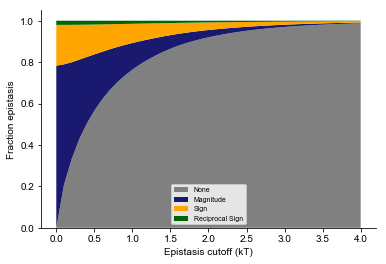

In [69]:
plot_threshold(energy_beta=BETA, energy_unit='kT',
               all_m=all_mag,all_s=all_sign,all_r=all_recip,
               filename='final-figures/Fig4F-cutoff-curves-kT.svg')

### SI 1A: kcal/mol energy units

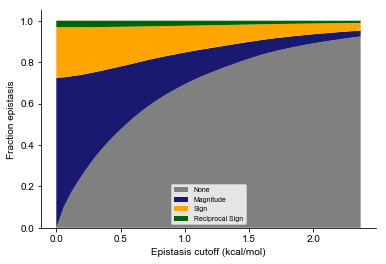

In [70]:
plot_threshold(energy_beta=beta_kcal, energy_unit='kcal/mol',
               all_m=all_mag_kcal,all_s=all_sign_kcal,all_r=all_recip_kcal,
               filename='final-figures/FigSIA-cutoff-curves-kcal.svg')

### SI 1B: kJ/mol energy units

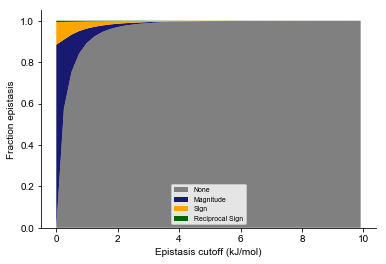

In [71]:
plot_threshold(energy_beta=beta_kj, energy_unit='kJ/mol',
               all_m=all_mag_kJ,all_s=all_sign_kJ,all_r=all_recip_kJ,
               filename='final-figures/FigSIB-cutoff-curves-kj.svg')